In [1]:
# Data imports and such
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from __future__ import division
# http://stat-computing.org/dataexpo/2009/the-data.html

In [2]:
airports = pd.read_excel('Data/airports new.xlt')
carriers  = pd.read_excel('Data/carriers.xls')
carriers.columns = ['UniqueCarrier','Description']
carriers.dropna(how="all", inplace=True) 

In [3]:
airports = airports.query("country=='USA'")
airports.head()

,iata,airport,city,state,country,lat,long
0,00M,Thigpen,Bay Springs,MS,USA,31.953765,-89.234505
1,00R,Livingston Municipal,Livingston,TX,USA,30.685861,-95.017928
2,00V,Meadow Lake,Colorado Springs,CO,USA,38.945749,-104.569893
3,01G,Perry-Warsaw,Perry,NY,USA,42.741347,-78.052081
4,01J,Hilliard Airpark,Hilliard,FL,USA,30.688012,-81.905944


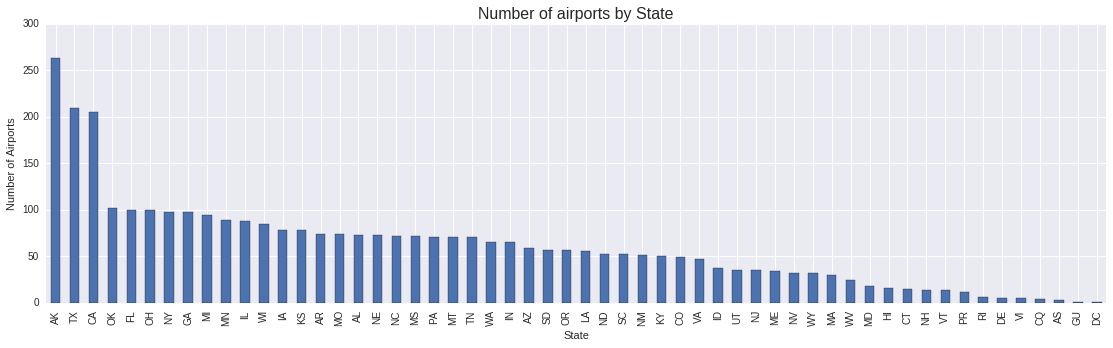

In [4]:
plt.figure(figsize=(19,5))
airports.state.value_counts().plot(kind='bar')
plt.title('Number of airports by State',fontsize=16)
plt.xlabel('State')
plt.ylabel('Number of Airports')

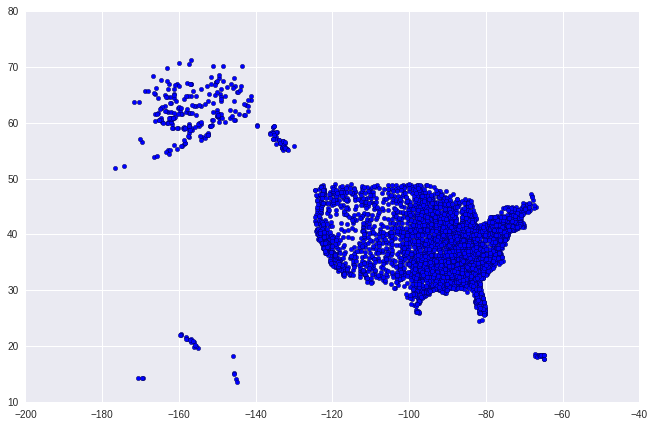

In [5]:
plt.figure(figsize=(11,7))
plt.scatter(airports.long,airports.lat)
plt.show()

In [6]:
trips_87 = pd.read_csv('Data/trips/1987.csv')
trips_87.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1987,10,14,3,741.0,730,912.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1987,10,15,4,729.0,730,903.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,1987,10,17,6,741.0,730,918.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,1987,10,18,7,729.0,730,847.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,1987,10,19,1,749.0,730,922.0,849,PS,1451,...,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [7]:
print("The total number of flights was " + str(len(trips_87)) + " whereas the number of not cancelled trips was " +str(trips_87.Cancelled.value_counts()[0]) + ". The percentage of cancellation is " + str(100 - 100*trips_87.Cancelled.value_counts()[0] / len(trips_87)) + " %" )

The total number of flights was 1311826 whereas the number of not cancelled trips was 1292141. The percentage of cancellation is 1.50058010742 %


In [8]:
data = trips_87.merge(carriers,on='UniqueCarrier')
data.columns

Index([u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime',
       u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier',
       u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime',
       u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance',
       u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted',
       u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay',
       u'LateAircraftDelay', u'Description'],
      dtype='object')

In [9]:
# Data from http://www.airportcodes.us/us-airports.htm
codes = pd.read_csv('Data/airport_codes.csv')
codes = codes.set_index('Code').to_dict()

In [10]:
data["origin_city"] = data["Origin"].map(codes['City'])
data["destin_city"] = data["Dest"].map(codes['City'])

In [11]:
# Average delays
delays = data.groupby(['origin_city','destin_city'])[['ArrDelay','DepDelay']].mean().reset_index()
delays['Total_delay'] = delays.ArrDelay+delays.DepDelay
delays.head()

,origin_city,destin_city,ArrDelay,DepDelay,Total_delay
0,Agana,Honolulu,7.301587,14.841270,22.142857
1,Albany,Atlanta,1.258824,5.647399,6.906222
2,Albany,BWI Airport,14.190114,7.954373,22.144487
3,Albany,Boston,21.000000,23.000000,44.000000
4,Albany,Buffalo,6.269939,6.368098,12.638037


In [35]:
import numpy as np
print('Airport with lenghtiest delays at departure: ' + delays.groupby('origin_city')['DepDelay'].mean().idxmax())
print('Airport with lenghtiest delays at arrival: ' + delays.groupby('destin_city')['ArrDelay'].mean().idxmax())

Airport with lenghtiest delays at departure: Pierre
Airport with lenghtiest delays at arrival: Pocatello


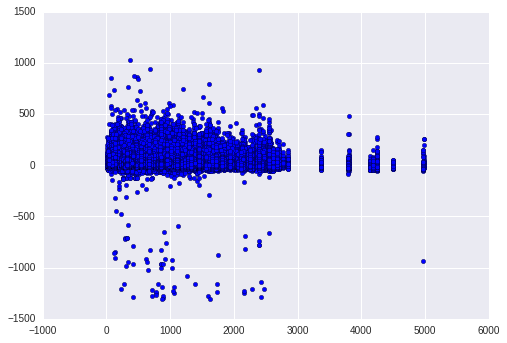

In [12]:
plt.scatter(data.Distance,data.ArrDelay)

In [13]:
airports = airports[['airport','city','lat','long']].set_index('city').to_dict()

In [14]:
data["origin_lat"] = data["origin_city"].map(airports['lat'])
data["origin_long"] = data["origin_city"].map(airports['long'])
data["destin_lat"] = data["destin_city"].map(airports['lat'])
data["destin_long"] = data["destin_city"].map(airports['long'])

In [15]:
# Trips
trips = data.groupby(['origin_city','destin_city'])[['UniqueCarrier']].count().reset_index()
trips.columns = ['origin_city','destin_city','Count']

In [16]:
trips.head()

,origin_city,destin_city,Count
0,Agana,Honolulu,64
1,Albany,Atlanta,173
2,Albany,BWI Airport,269
3,Albany,Boston,1
4,Albany,Buffalo,164


In [17]:
"""
import os
lst = []
path = 'Data/trips/'
test = pd.DataFrame([])
for name in os.listdir(path):
    df = pd.read_csv(path+name,index_col=None, header=0)
    #lst.append(df)
"""

"\nimport os\nlst = []\npath = 'Data/trips/'\ntest = pd.DataFrame([])\nfor name in os.listdir(path):\n    df = pd.read_csv(path+name,index_col=None, header=0)\n    #lst.append(df)\n"

In [18]:
import numpy as np
data = data[data['origin_lat'].notnull()]
data = data[data['origin_long'].notnull()]
#data.head()
data['coord'] = zip(data['origin_long'],data['origin_lat'])
pos = data[['origin_city','coord']].dropna().set_index('origin_city').to_dict()

In [19]:
#data[data['origin_city']=='Pocatello']['coord'].tail()
print(len(data[['origin_city','coord']].dropna()))
print(len(data[['origin_city','coord']]))

1219269
1219864


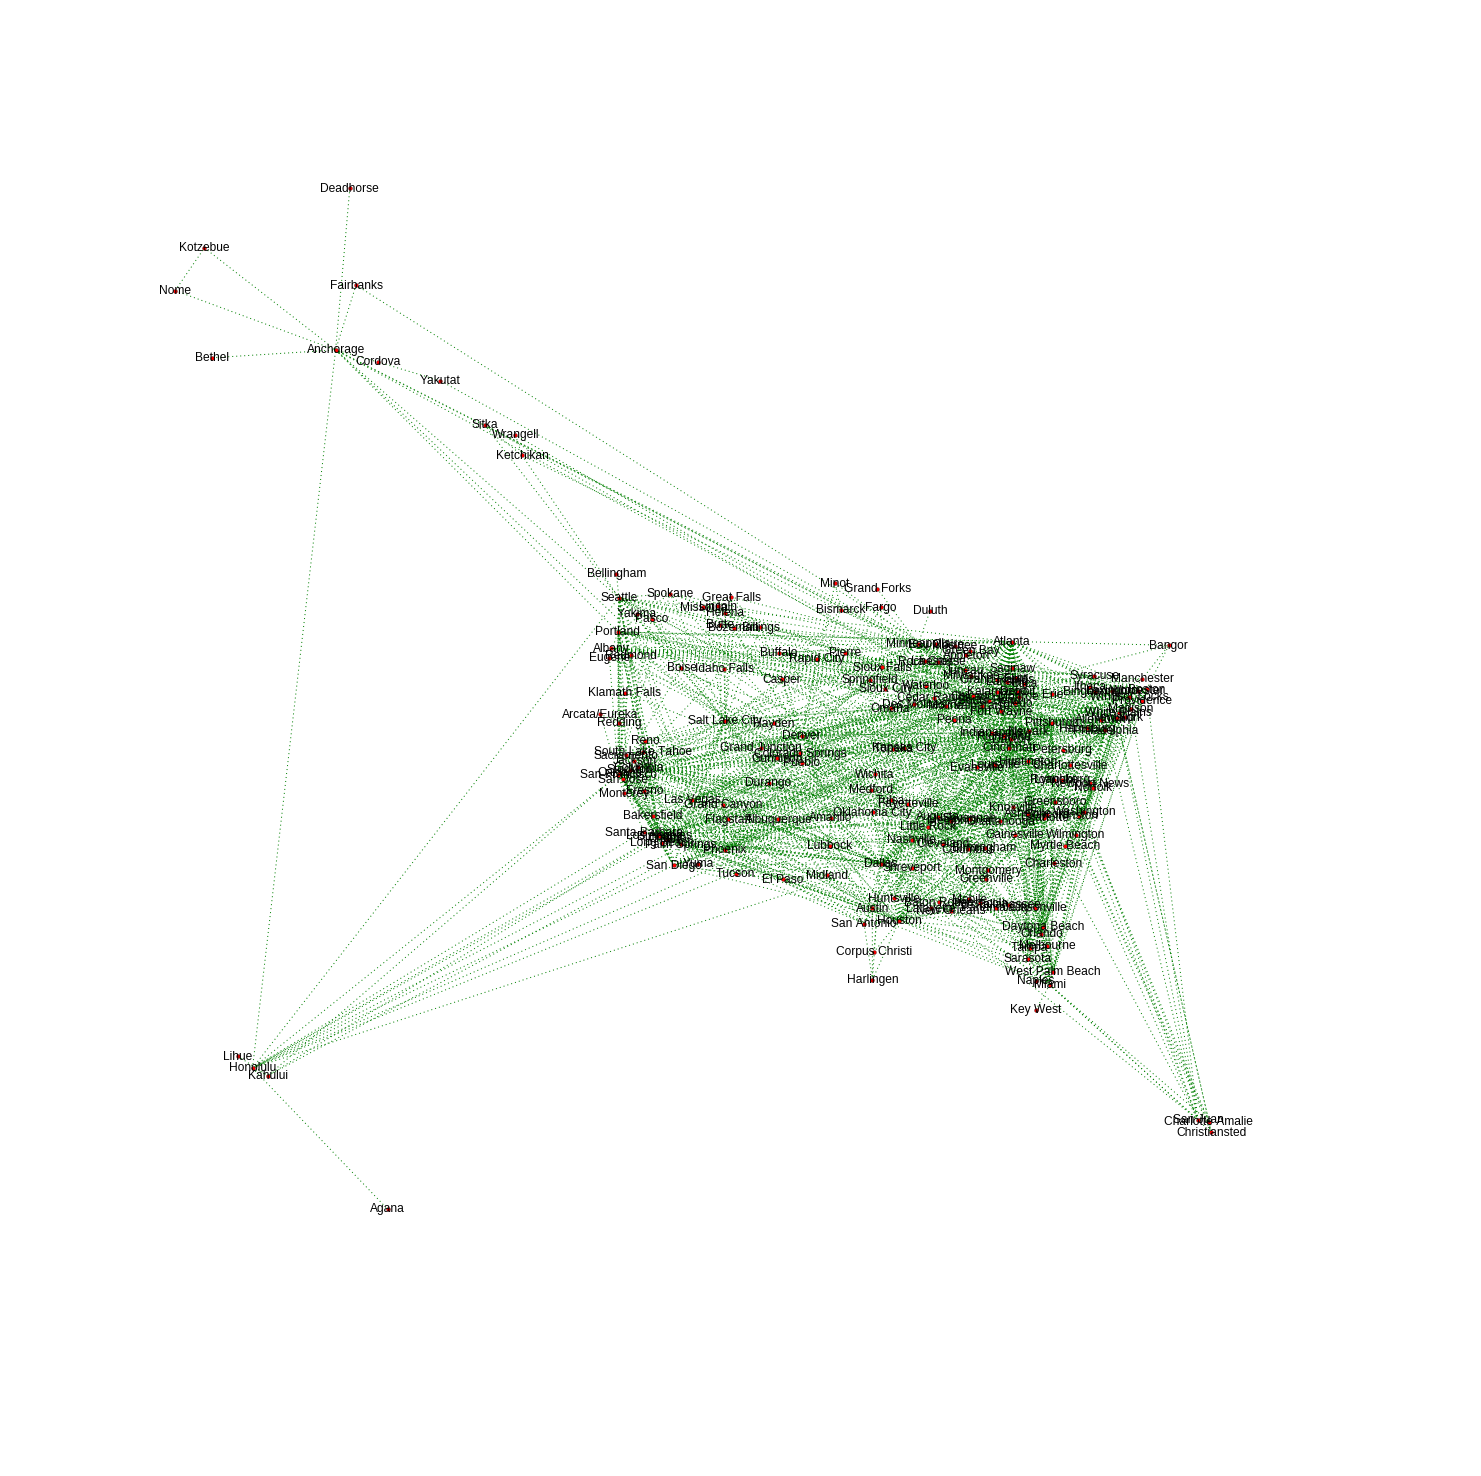

In [20]:
#create an empty undirected network
G=nx.Graph()
G.add_nodes_from(list(pd.unique(trips.origin_city.dropna())))
G.add_weighted_edges_from(zip(trips['origin_city'].dropna(),trips['destin_city'].dropna(),trips['Count'].dropna()))
#np.random.seed(2015) #fix the origin of random generator - see below why
#now let's visualize, which turns out to be fairly simple with networkx

G.remove_nodes_from(['Keahole','Orange County','Gulfport','North Canton','Elmira / Corning','Champaign','Fort Lauderdale','Rdu Airport','Avoca','Saint Petersburg','Saint Louis','Blountville','BWI Airport','Fort Myers','Mcallen','Pocatello','South Burlington'])
plt.figure(figsize=(20,20))
nx.draw(G,pos=pos['coord'],with_labels=True,node_size=15,style='dotted',edge_color='green')

In [21]:
d=G.degree().values()
j=np.argmax(d)
print('Most connected airport is {0} with {1} connections'.format(G.degree().keys()[j],d[j]))

Most connected airport is Chicago with 98 connections


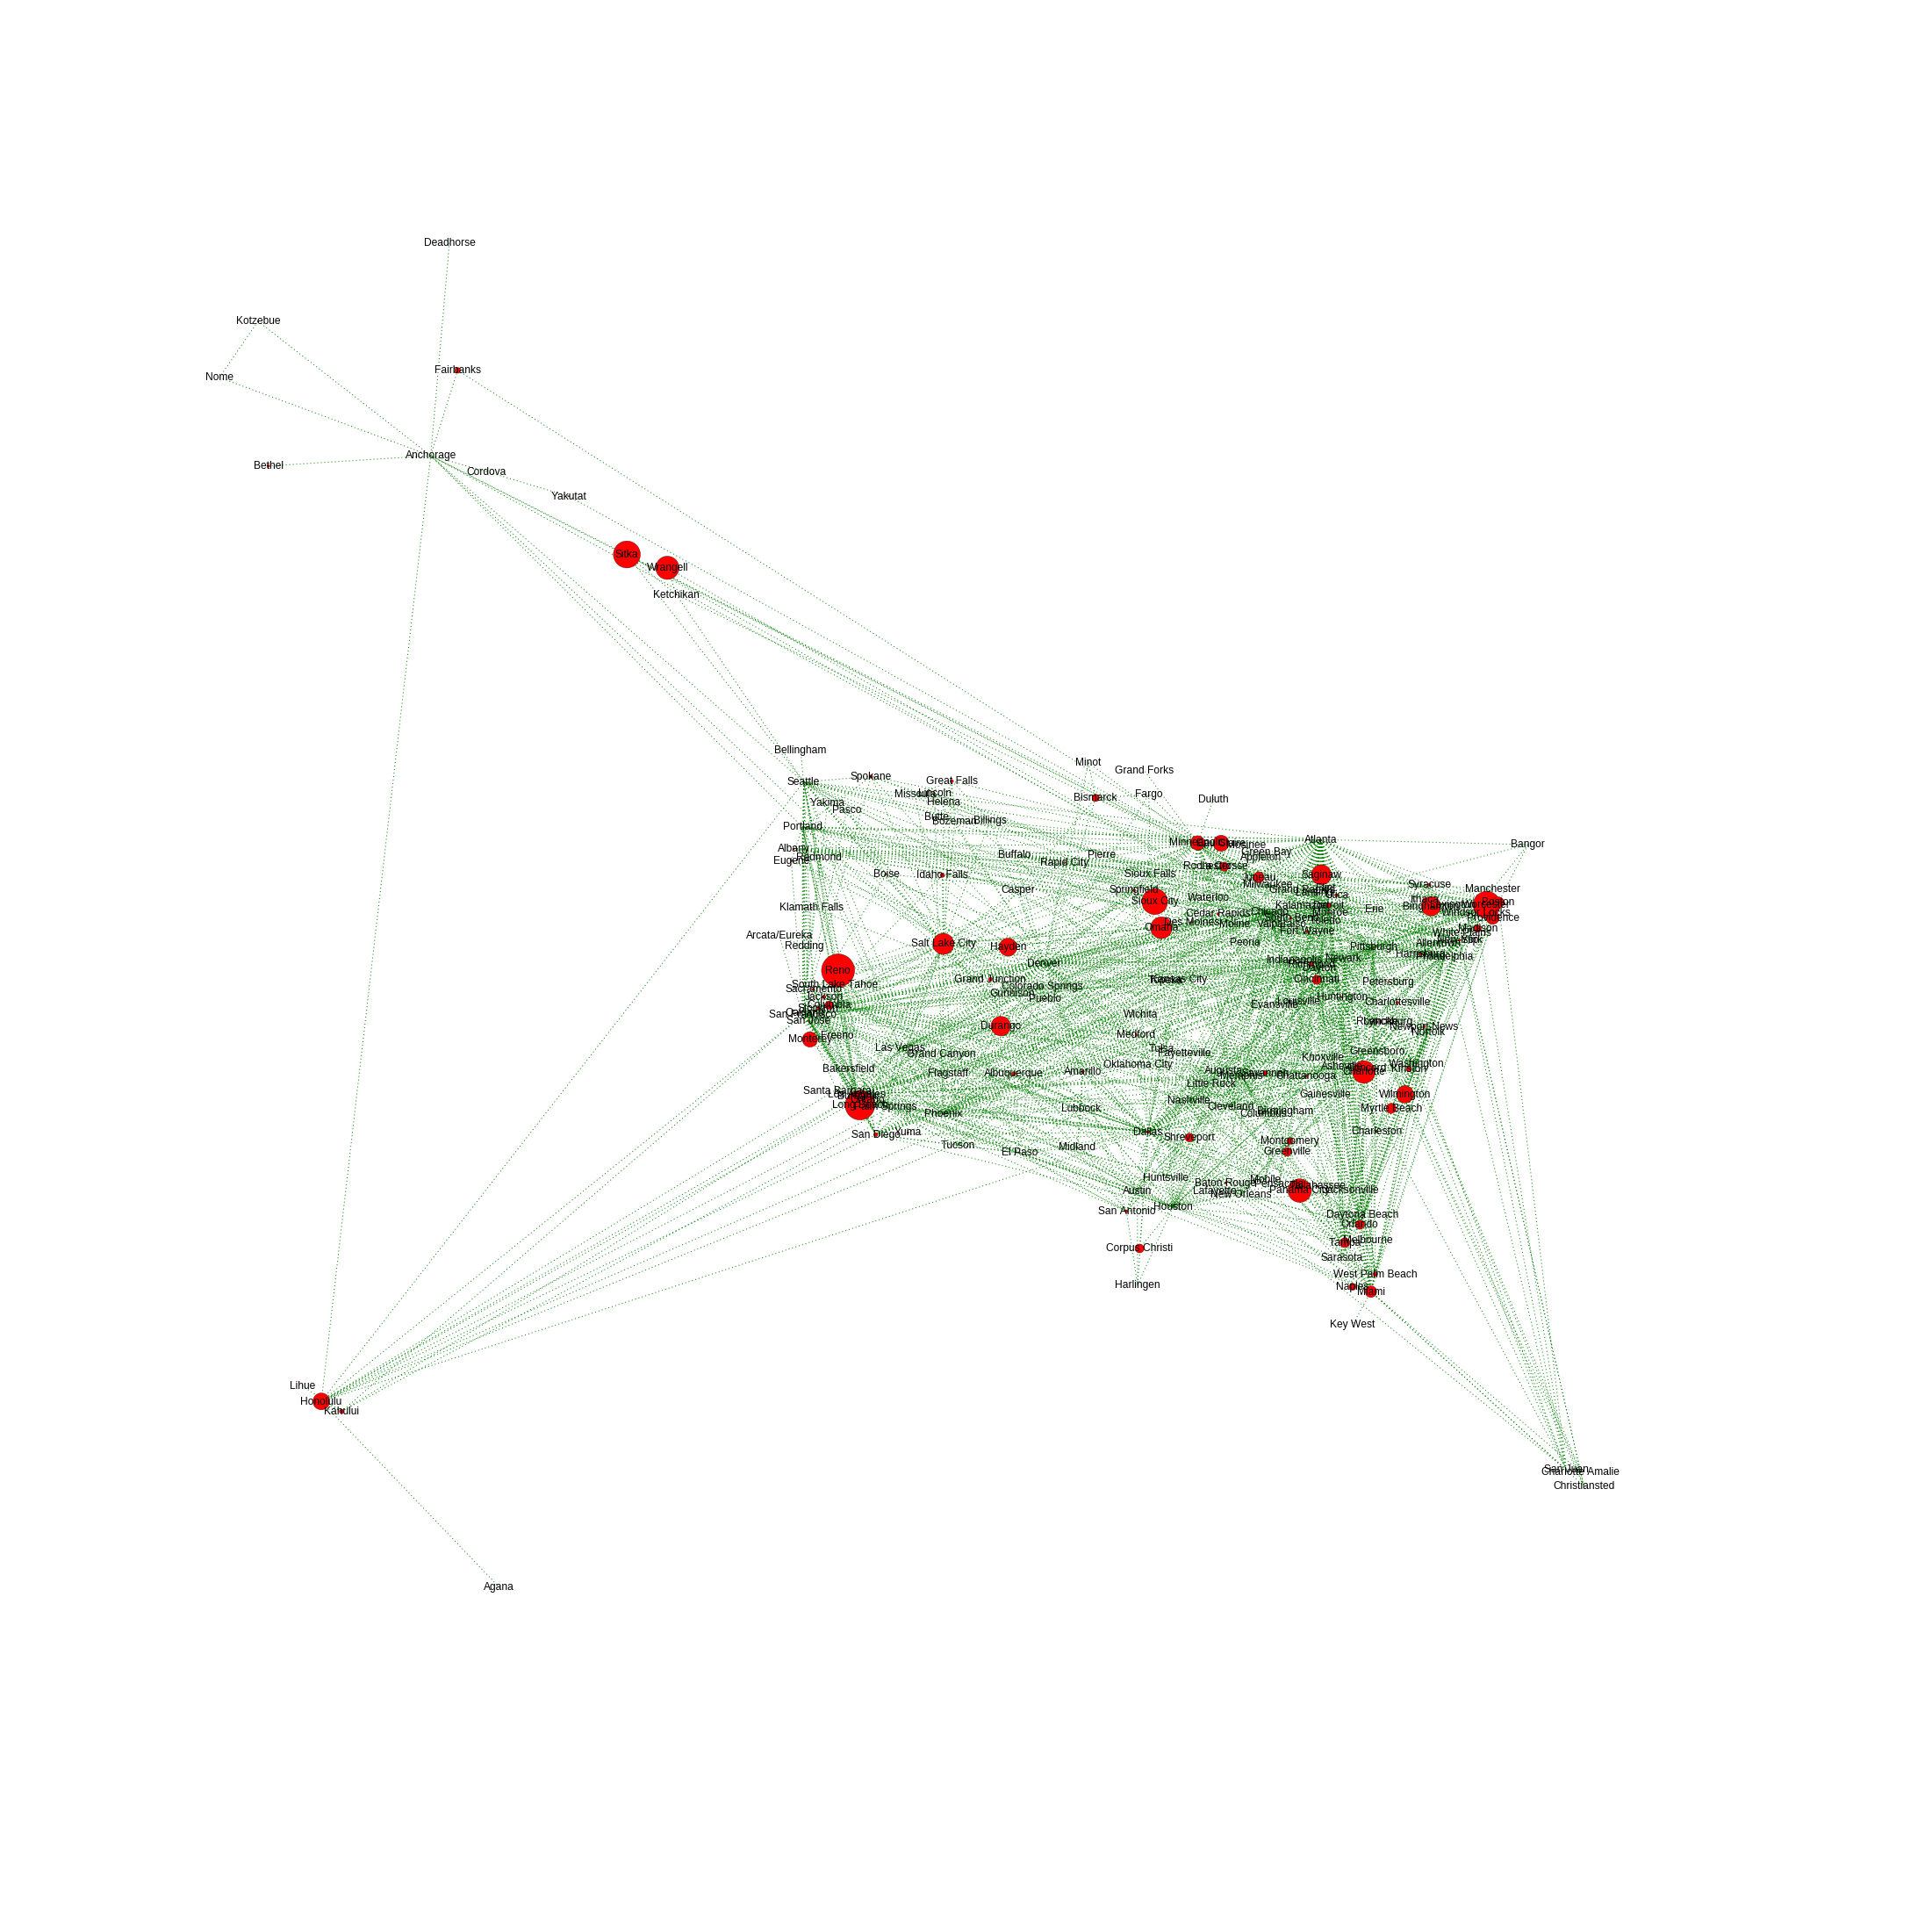

In [22]:
plt.figure(figsize=(30,30))
nx.draw(G,pos=pos['coord'],with_labels=True,
        node_size=1E4*np.array(nx.betweenness_centrality(G).values()),style='dotted',edge_color='green')

In [23]:
data = data[[ u'ActualElapsedTime','UniqueCarrier' ,u'CRSElapsedTime','CarrierDelay', u'origin_city', u'destin_city',u'origin_lat', u'origin_long', u'destin_lat', u'destin_long', u'coord']]
data.head()

,ActualElapsedTime,UniqueCarrier,CRSElapsedTime,CarrierDelay,origin_city,destin_city,origin_lat,origin_long,destin_lat,destin_long,coord
0,91.0,PS,79,NaN,San Diego,San Francisco,32.572306,-116.98025,37.619002,-122.374843,"(-116.98025, 32.57230556)"
1,94.0,PS,79,NaN,San Diego,San Francisco,32.572306,-116.98025,37.619002,-122.374843,"(-116.98025, 32.57230556)"
2,97.0,PS,79,NaN,San Diego,San Francisco,32.572306,-116.98025,37.619002,-122.374843,"(-116.98025, 32.57230556)"
3,78.0,PS,79,NaN,San Diego,San Francisco,32.572306,-116.98025,37.619002,-122.374843,"(-116.98025, 32.57230556)"
4,93.0,PS,79,NaN,San Diego,San Francisco,32.572306,-116.98025,37.619002,-122.374843,"(-116.98025, 32.57230556)"
